# Alternative excision analysis

### Aim
Analyze genome-wide alternative excision in ICOP knockdowns and compare them with the puplished data of the ISWI1 knockdown. New KDs analyzed in this notebook: ICOP1-KD, ICOP2-KD, ICOP1_2-KD, ND7-KD

### Input
new enriched MAC DNA was send for whole genome sequencing. In the PARTIES pipeline the MILROD module (old one from PIES) was run on the bowtie mapped .bam files. Output is a .gff3 file that was zipped using gzip command.

### What this notebook does
1. Histogram of genome-wide alternative excision per IES (%)
2. Historgam of length distribution of alternatively excised IES in each sample
3. Barplot of absolute numbers of alternative excision events in each sample
4. Barplot of percentage of alternative excision events in each sample 
5. Histogram of length differences in partial internal and partial external excision events

### Import required packages

In [1]:
#!/usr/bin/env python

import sys
#from sys import argv
from Bio import SeqIO, Seq
from re import compile
import gzip
from scipy import *
from matplotlib import * 
import matplotlib.pyplot as plt
from pylab import * 
#from scipy import stats
from collections import OrderedDict
import numpy as np
import pandas as pd
#import gffpandas.gffpandas as gffpd
from functools import reduce

## Genome-wide alternative excision per IES (%)

In [29]:
#this script analyses the percentage of alternative excision for each IES
# incoorperate storage of alternative excision in data frames

kd_alt_fracs = []
fns = ["ND7_down_MILORD.gff3.gz","ISWI1_down_MILORD.gff3.gz","ICOP1_down_MILORD.gff3.gz",
       "ICOP2_down_MILORD.gff3.gz", "ICOP1_2_MILORD.gff3.gz"]
names = ["CTRL-KD","ISWI1-KD","ICOP1-KD", "ICOP2-KD", "ICOP1/2-KD"]

count = int(-1)
dfs = []
columns = []

#loop through samples
for fn in fns:
    count += 1
    ies_d = {}
    alt_d = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')

            #for each properly excised IES store the number of reads
            if kind == 'IES':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                ies_d.setdefault(ies_id, 0)
                ies_d[ies_id] += len(read_names)
                alt_d.setdefault(ies_id, 0)
            #for each alternatively excised IES store the number of reads (adds up for subtypes)
            elif kind == 'ALTERNATIVE':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                alt_d.setdefault(ies_id, 0)
                alt_d[ies_id] += len(read_names)
                ies_d.setdefault(ies_id, 0)
    
    # create a big data frame with all read counts
    # data frame with standard excised reads for sample
    df_ies = pd.DataFrame.from_dict(ies_d, orient = 'index', columns = [f'{names[count]}_std'])
    df_ies = df_ies.reset_index().rename(columns={'index': 'IES_ID'})
    
    # data frame with alternatively excised reads for sample
    df_alt = pd.DataFrame.from_dict(alt_d, orient = 'index', columns = [f'{names[count]}_alt'])
    df_alt = df_alt.reset_index().rename(columns={'index': 'IES_ID'})
    
    # combine to one data frame per sample 
    df_data = pd.DataFrame.merge(df_ies, df_alt, on='IES_ID', how = 'outer')
    # calculate alternative excision percentage for each IES in the sample
    df_data[f"{names[count]}_frac"] = ((df_data[f'{names[count]}_alt'])/(df_data[f'{names[count]}_alt']\
                                                                        +df_data[f'{names[count]}_std']))*100
    # store sample data frame in list
    dfs.append(df_data)
    
    # generate metrics to print as table 
    colnames = ['sample','median', 'mean', 'all IES','IES==0', 'IES>0','IES>=50','IES==100']
    columns.append([names[count], median(df_data[f"{names[count]}_frac"]),
                    mean(df_data[f"{names[count]}_frac"]), len(ies_d), 
                    len(df_data[df_data[f"{names[count]}_frac"]== 0]),
                    len(df_data[df_data[f"{names[count]}_frac"] > 0]), 
                    len(df_data[df_data[f"{names[count]}_frac"] >= 50]),
                    len(df_data[df_data[f"{names[count]}_frac"] == 100])])
    
    
# combine all samples into one big data frame
df = reduce(lambda left,right: pd.merge(left,right,on=['IES_ID'], how='outer'), dfs).fillna(np.nan)

    

table = pd.DataFrame(columns, columns = colnames)
print(table)

table.to_csv("statistics_alt-ex.csv")

       sample    median       mean  all IES  IES==0  IES>0  IES>=50  IES==100
0     CTRL-KD  0.000000   2.588665    41311   39164   2147      944       631
1    ISWI1-KD  4.545455  10.856721    43983   18222  25761     1963       812
2    ICOP1-KD  0.000000   8.968224    42237   28106  14131     2244       888
3    ICOP2-KD  0.000000   5.997431    41573   34036   7537     1694       788
4  ICOP1/2-KD  0.000000   6.525131    41767   33870   7897     1991       795


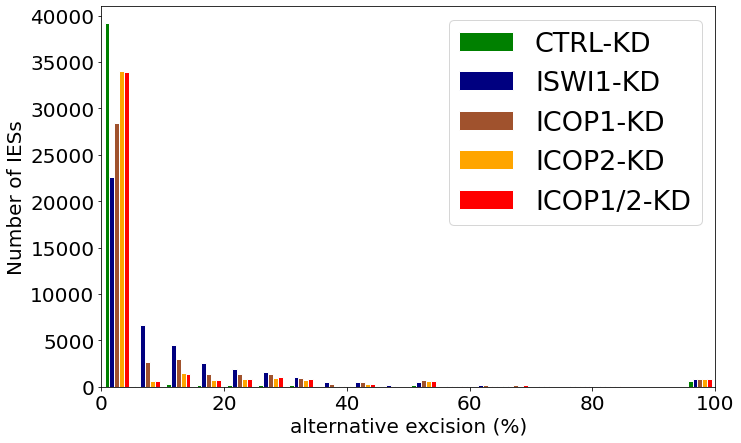

In [3]:
#plot the genome-wide alternative excision distribution (non-cropped)

# retrive fraction data
fractions = []
for na in names:
    fraction = df[f"{na}_frac"]
    fractions.append(fraction)
    
labels = ["CTRL-KD","ISWI1-KD","ICOP1-KD", "ICOP2-KD", "ICOP1/2-KD"]

plt.figure(figsize=(11,7))
hist(fractions, bins=20, ec='white', log=False, 
     color=['green', 'navy', 'sienna', 'orange', 'red'],
     label=labels)
axis(ymax=41000, xmax=100, xmin=0)
plt.ylabel("Number of IESs", wrap = True, fontsize = 20)
plt.xlabel("alternative excision (%)", wrap = True, fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize = 27);


plt.savefig("ICOPs_alt-ex_100_down.pdf", bbox_inches='tight')

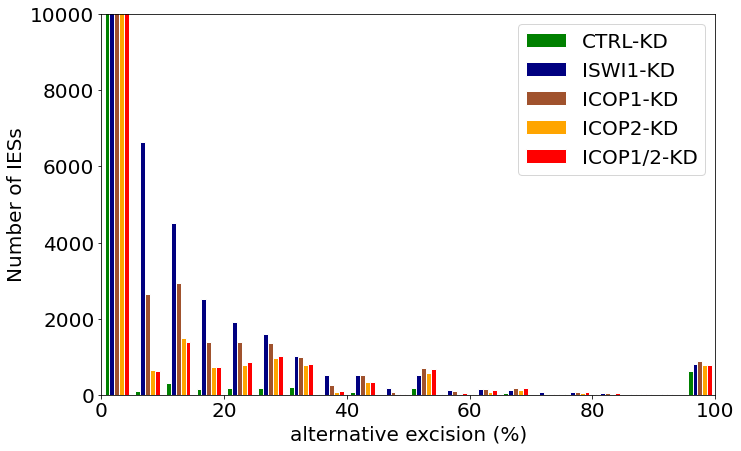

In [4]:
#plot the genome-wide alternative excision distribution (cropped)

plt.figure(figsize=(11,7))
hist(fractions, bins=20, ec='white', log=False, 
     color=['green', 'navy', 'sienna', 'orange', 'red'],
     label=labels)
axis(ymax=10000, xmax=100, xmin=0)
plt.ylabel("Number of IESs", wrap = True, fontsize = 20)
plt.xlabel("alternative excision (%)", wrap = True, fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize = 20);


plt.savefig("ICOPs_alt-ex_100_downS.pdf", bbox_inches='tight')

### Length distribution for alternatively excised IESs

In [5]:
#this script acquires the lengths of alternatively excised IESs

# create data frame with reference IES lengths
df_length = pd.read_csv('IES_length.txt.gz',compression = 'gzip',sep=" ",\
                        header=None, names=['IES_ID','ref_length'])

dfs_len = OrderedDict([(na, []) for na in names])
count = int(-1)

#loop through the samples to get subtypes for alternative excision
for fn in fns:
    count += 1
    ies_len = {}
    alt_len = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')
            subtype = atoms[-1].split(";")[-5].replace("subtype=", '')
            
            if kind == 'IES':
                sequence = atoms[-1].split(";")[11].replace("sequence=", '')
                ies_len[ies_id] = len(sequence)
            #for alternatively excised IES store the length of the alternative IES
            elif kind == 'ALTERNATIVE':
                sequence = atoms[-1].split(";")[11].replace("sequence=", '')
                alt_len.setdefault(ies_id, []).append(len(sequence))
                
    # data frame with alternative excised reads lengths for sample
    df_allen = pd.DataFrame.from_dict(alt_len, orient = 'index')
    df_allen = df_allen.reset_index().rename(columns={'index': 'IES_ID'})
    
    # combine to one data frame per sample 
    df_altlen = pd.DataFrame.merge(df_length, df_allen, on='IES_ID', how = 'inner')
    
    # store sample data frame in list
    dfs_len[names[count]] = df_altlen


In [6]:
# extract the alternative lengths from the data frames

# Create an empty dictionary to store the extracted values
extracted_values = {}

# get reference values
extracted_values['ref_length'] = df_length['ref_length']

# Iterate over each sample in the dictionary
for sample_name, df in dfs_len.items():
    # Extract values from the dataframe, ignoring the first two columns
    extracted_values[sample_name] = df.iloc[:, 2:].values.flatten().tolist()

    # Remove NaN values from the extracted list
    extracted_values[sample_name] = [x for x in extracted_values[sample_name] if (~np.isnan(x))]

In [30]:
# get statistics for the alternative lengths

table_rows = []

for name, values in extracted_values.items():
    sample = name
    minimum = min(values)
    maxium = max(values)
    
    table_rows.append([name, min(values), max(values), np.mean(values), np.median(values)])
    
table_names = ['sample','min','max', 'mean', 'median']
table2 = pd.DataFrame(table_rows, columns = table_names)
print(table2)
table2.to_csv("min-max_length_alt-ex.csv")

       sample   min     max        mean  median
0  ref_length  20.0  5314.0   79.129274    50.0
1     CTRL-KD   9.0  9032.0  260.082198    76.0
2    ISWI1-KD   5.0  9892.0  209.045451    73.0
3    ICOP1-KD   6.0  9590.0  197.718871    67.0
4    ICOP2-KD   5.0  9467.0  143.149613    65.0
5  ICOP1/2-KD   5.0  9878.0  186.570144    67.0


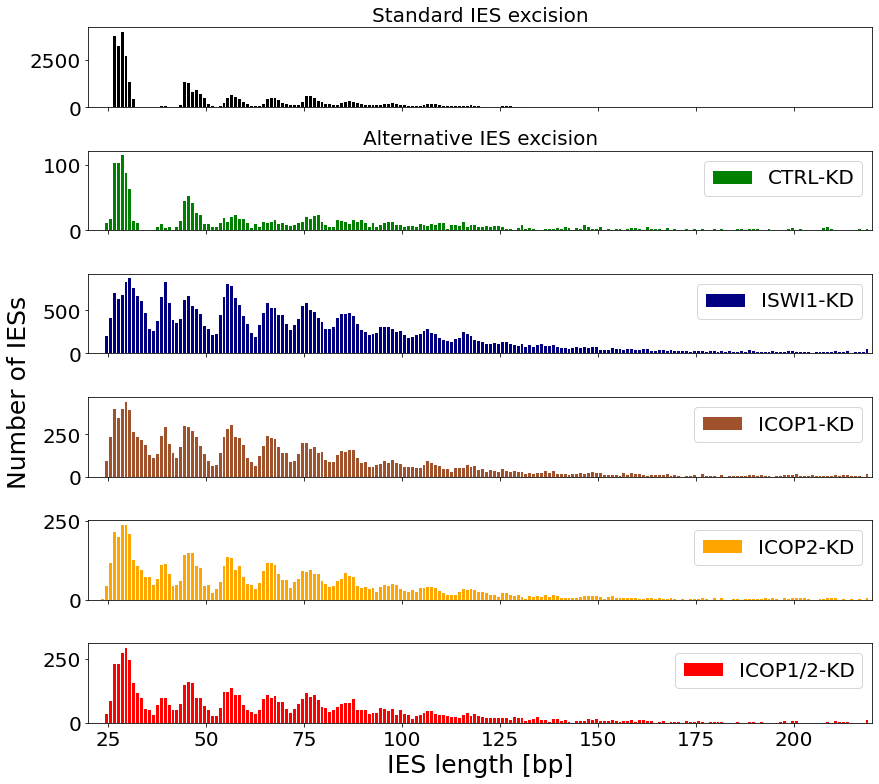

In [19]:
# plot the lengths of alternatively excised IESs

fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, ncols=1, sharex=True, figsize = (12,11));

ax0.hist(extracted_values['ref_length'], bins=range(20, 220, 1), ec='white', fc='black');
ax1.hist(extracted_values[names[0]], bins=range(20, 220, 1), ec='white', fc='green', 
         label = "CTRL-KD");
ax2.hist(extracted_values[names[1]], bins=range(20, 220, 1), ec='white', fc='navy', 
         label = "ISWI1-KD");
ax3.hist(extracted_values[names[2]], bins=range(20, 220, 1), ec='white', fc='sienna', 
         label = "ICOP1-KD");
ax4.hist(extracted_values[names[3]], bins=range(20, 220, 1), ec='white', fc='orange', 
         label = "ICOP2-KD");
ax5.hist(extracted_values[names[4]], bins=range(20, 220, 1), ec='white', fc='red', 
         label = "ICOP1/2-KD");

ax1.legend(fontsize=20);
ax2.legend(fontsize=20);
ax3.legend(fontsize=20);
ax4.legend(fontsize=20);
ax5.legend(fontsize=20);

ax0.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax5.tick_params(axis='both', which='major', labelsize=20)

ax0.set_title("Standard IES excision", fontsize=20)
ax1.set_title("Alternative IES excision", fontsize=20)

ax5.set_xlabel('IES length [bp]', fontsize=25)
ax5.set_xlim([20,220]);

fig.text(0.00001, 0.5, 'Number of IESs', ha='center', va='center', fontsize=25, rotation='vertical');
fig.tight_layout();

fig.savefig("ICOPs_alt_length_down.pdf", bbox_inches='tight')

In [9]:
# where do the IESs in the forbidden peak come from?

# Create an empty dictionary to store the extracted values
forbidden_len = {}
forbidden_id = {}

# Iterate over each sample in the dictionary
for sample_name, df in dfs_len.items():
    # Initialize an empty list to store the extracted reference lengths
    ref_lengths = []
    ref_ids = []

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # Iterate over each value in the row, starting from the third column
        for value in row.values[2:]:
            # Check if the value is between 34 and 44 (inclusive)
            if 34 <= value <= 44:
                # Retrieve the corresponding reference length from the second column
                ref_length = row['ref_length']
                ref_id = row['IES_ID']
                # Append the reference length to the list
                ref_lengths.append(ref_length)
                ref_ids.append(ref_id)

    # Store the extracted reference lengths in the dictionary using the sample name as the key
    forbidden_len[sample_name] = ref_lengths
    forbidden_id[sample_name] = ref_ids

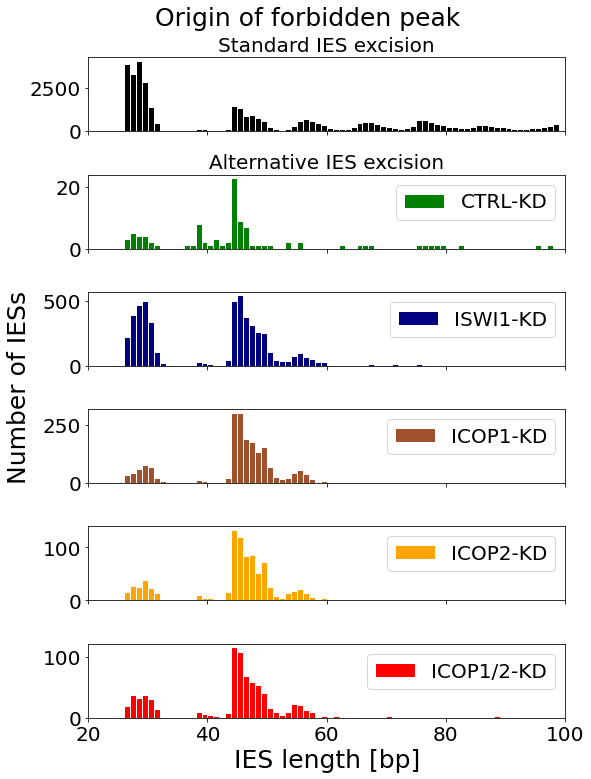

In [18]:
# plot the lengths form where the forbidden peak comes from

fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, ncols=1, sharex=True, figsize = (8,11));

ax0.hist(extracted_values['ref_length'], bins=range(20, 100, 1), ec='white', fc='black');
ax1.hist(forbidden_len[names[0]], bins=range(20, 100, 1), ec='white', fc='green', 
         label = "CTRL-KD");
ax2.hist(forbidden_len[names[1]], bins=range(20, 100, 1), ec='white', fc='navy', 
         label = "ISWI1-KD");
ax3.hist(forbidden_len[names[2]], bins=range(20, 100, 1), ec='white', fc='sienna', 
         label = "ICOP1-KD");
ax4.hist(forbidden_len[names[3]], bins=range(20, 100, 1), ec='white', fc='orange', 
         label = "ICOP2-KD");
ax5.hist(forbidden_len[names[4]], bins=range(20, 100, 1), ec='white', fc='red', 
         label = "ICOP1/2-KD");

ax1.legend(fontsize=20);
ax2.legend(fontsize=20);
ax3.legend(fontsize=20);
ax4.legend(fontsize=20);
ax5.legend(fontsize=20);

ax0.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax5.tick_params(axis='both', which='major', labelsize=20)

ax0.set_title("Standard IES excision", fontsize=20)
ax1.set_title("Alternative IES excision", fontsize=20)

ax5.set_xlabel('IES length [bp]', fontsize=25)
ax5.set_xlim([20,100]);

fig.suptitle("Origin of forbidden peak", fontsize=25);
fig.text(0.00001, 0.5, 'Number of IESs', ha='center', va='center', fontsize=25, rotation='vertical');
fig.tight_layout();

fig.savefig("ICOPs_alt_length_down_oriFB.pdf", bbox_inches='tight')

## Frequencies of alternative excision types
This script get the numbers of types of alternative excsision in each sample and displays in barplot

In [11]:
#this script acquires the type of alternative excision genome wide

#fns = ["ND7_down_MILORD.gff3.gz","ISWI1_down_MILORD.gff3.gz","ICOP1_down_MILORD.gff3.gz",
#       "ICOP2_down_MILORD.gff3.gz", "ICOP1_2_MILORD.gff3.gz"]
#names = ["ND7-KD","ISWI1-KD","ICOP1-KD", "ICOP2-KD", "ICOP1_2-KD"]
count = int(-1)

#to have the date sorted by KDs also make a dict
subs = OrderedDict([(na, []) for na in names])

# lists for boxplot
headers = []
p_internal = []
p_external = []
internal = []
external = []
overlap = []

#lists for proportional boxplots
prop_p_internal = []
prop_p_external = []
prop_internal = []
prop_external = []
prop_overlap = []

for fn in fns:
    count += 1
    part_in = 0
    part_ex = 0
    inter = 0
    exter = 0
    over = 0
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
        
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')
            subtype = atoms[-1].split(";")[-5].replace("subtype=", '')
        
            if kind == 'ALTERNATIVE':
                if subtype == 'PARTIAL_INTERNAL':
                    part_in += 1
                if subtype == 'PARTIAL_EXTERNAL':
                    part_ex += 1
                if subtype == 'INTERNAL':
                    inter += 1
                if subtype == 'EXTERNAL':
                    exter += 1
                if subtype == 'OVERLAPPING':
                    over += 1
    
    #store data ordered by KDs in dict
    alt_list = [part_in, part_ex, inter, exter, over]
    subs[names[count]].append(alt_list)
    
    #for box plots store them in seperate lists
    headers.append(names[count])
    p_internal.append(part_in)
    p_external.append(part_ex)
    internal.append(inter)
    external.append(exter)
    overlap.append(over)
    
    #for proportional boxplot store percentages in seperate lists
    prop_part_in = part_in/sum(subs[names[count]])
    prop_part_ex = part_ex/sum(subs[names[count]])
    prop_inter = inter/sum(subs[names[count]])
    prop_exter = exter/sum(subs[names[count]])
    prop_over = over/sum(subs[names[count]])
    
    prop_p_internal.append(prop_part_in)
    prop_p_external.append(prop_part_ex)
    prop_internal.append(prop_inter)
    prop_external.append(prop_exter)
    prop_overlap.append(prop_over)
    

In [31]:
conames = list(subs.keys())
co = []
index = ["partial_internal", "partial_external", "internal", "external", "overlap"]
to_append = [prop_p_internal, prop_p_external, prop_internal, prop_external, prop_overlap]
for u in to_append:
    co.append(u)
tab = pd.DataFrame(co, columns = conames, index = index)
print(tab)
tab.to_csv('ICOP-alex-events.csv')

                   CTRL-KD  ISWI1-KD  ICOP1-KD  ICOP2-KD  ICOP1/2-KD
partial_internal  0.306644  0.426697  0.566458  0.573708    0.469770
partial_external  0.328365  0.420035  0.277467  0.277257    0.338363
internal          0.031090  0.042601  0.038346  0.029714    0.052006
external          0.065588  0.041016  0.041792  0.026246    0.032531
overlap           0.268313  0.069651  0.075937  0.093074    0.107330


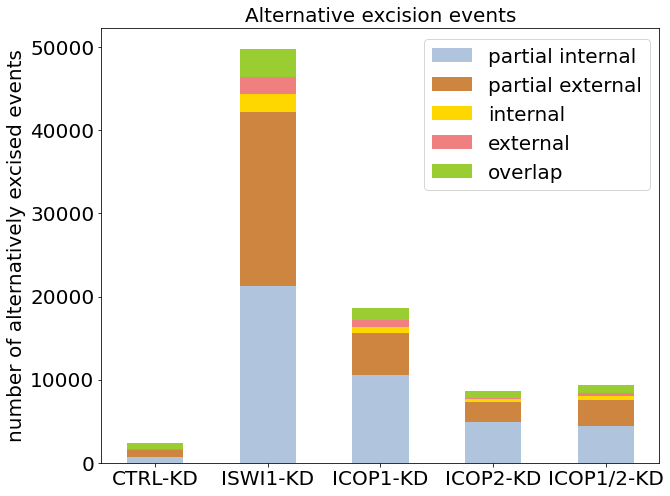

In [13]:
# stacked bar plot with absolut number as y-axis
width = 0.5       # the width of the bars: can also be len(x) sequence
n_p_internal = np.array(p_internal)
n_p_external = np.array(p_external)
n_internal = np.array(internal)
n_external = np.array(external)
n_overlap = np.array(overlap)


# make figure
fig, ax = plt.subplots(figsize = (10,8))

ax.bar(headers, n_p_internal, width, label='partial internal', color='lightsteelblue')
ax.bar(headers, n_p_external, width, bottom=n_p_internal, label='partial external', color='peru')
ax.bar(headers, n_internal, width, bottom=(n_p_internal+n_p_external), label='internal', color='gold')
ax.bar(headers, n_external, width, bottom=(n_p_internal+n_p_external+n_internal), label='external', 
       color='lightcoral')
ax.bar(headers, n_overlap, width, bottom=(n_p_internal+n_p_external+n_internal+n_external), 
       label='overlap', color='yellowgreen')

ax.set_ylabel('number of alternatively excised events', wrap = True, fontsize = 20)
ax.set_title('Alternative excision events', wrap = True, fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc='center left', bbox_to_anchor=(0.56, 0.8), fancybox=True, fontsize = 20);

fig.savefig("ICOPs_ex_events.pdf", bbox_inches='tight')

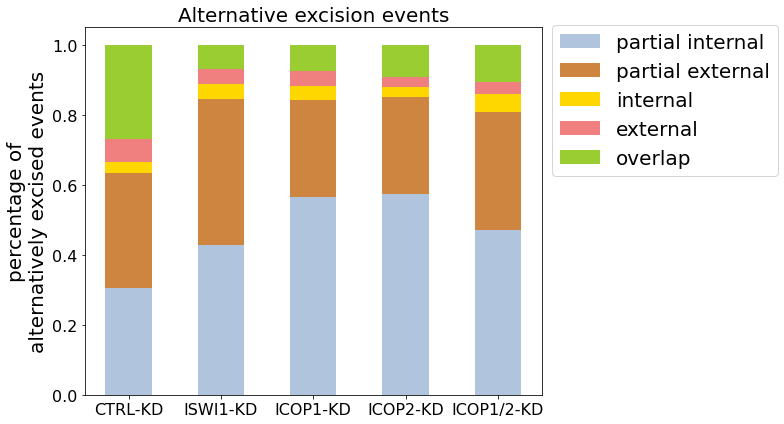

In [27]:
# stacked bar plot with percentage as y-axis
width = 0.5       # the width of the bars: can also be len(x) sequence
n_prop_p_internal = np.array(prop_p_internal)
n_prop_p_external = np.array(prop_p_external)
n_prop_internal = np.array(prop_internal)
n_prop_external = np.array(prop_external)
n_prop_overlap = np.array(prop_overlap)

# make figure
fig, ax = plt.subplots(figsize = (11,6))

ax.bar(headers, n_prop_p_internal, width, label='partial internal', color='lightsteelblue')
ax.bar(headers, n_prop_p_external, width, bottom=n_prop_p_internal, label='partial external', color='peru')
ax.bar(headers, n_prop_internal, width, bottom=(n_prop_p_internal+n_prop_p_external), label='internal', 
       color='gold')
ax.bar(headers, n_prop_external, width, bottom=(n_prop_p_internal+n_prop_p_external+n_prop_internal), 
       label='external', color='lightcoral')
ax.bar(headers, n_prop_overlap, width, label='overlap', color='yellowgreen',
       bottom=(n_prop_p_internal+n_prop_p_external+n_prop_internal+n_prop_external)) 

ax.set_ylabel('percentage of\nalternatively excised events', wrap = True, fontsize = 20)
ax.set_title('Alternative excision events', wrap = True, fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.80), fancybox=True, fontsize = 20);
fig.tight_layout()

fig.savefig("ICOPs_ex_events_prop.pdf", bbox_inches='tight', transparent="True")

### Get the length differences for partial internal and partial external

In [33]:
li = []
zahl = int(-1)
for i in range(1,10):
    zahl += 1
    li.append(zahl)
li

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [34]:
#this script is to analyse parially internal and partially external excision
count = int(-1)
partial_storage = {}

for fn in fns:
    count += 1
    #store all internally exicised IESs with their length difference in a dict
    len_d_int = {}
    #store all externally exicised IESs with their length difference in a dict
    len_d_ext = {}
    
    # store the reference lengths of partial internally or externally excised IESs in lists
    pext_ref_len = []
    pint_ref_len = []

    
    for line in gzip.open(fn, mode='rt'):   
        if line[0] != '#':
            atoms = line.split()  
        
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')
            subtype = atoms[-1].split(";")[-5].replace("subtype=", '')
            
            if kind == 'ALTERNATIVE':
                if subtype == 'PARTIAL_INTERNAL':
                    start = int(atoms[-1].split(";")[-6].replace("start=", ''))
                    end = int(atoms[-1].split(";")[4].replace("end=", ''))
                    calc_len = end - start
                    ref_ies_len = int(df_length.loc[df_length['IES_ID'] == ies_id]["ref_length"])
                    len_d_int.setdefault(ies_id, []).append(ref_ies_len - calc_len)
                    pint_ref_len.append(ref_ies_len)
            
                if subtype == 'PARTIAL_EXTERNAL':
                    start = int(atoms[-1].split(";")[-6].replace("start=", ''))
                    end = int(atoms[-1].split(";")[4].replace("end=", ''))
                    calc_len = end - start
                    ref_ies_len = int(df_length.loc[df_length['IES_ID'] == ies_id]["ref_length"])
                    len_d_ext.setdefault(ies_id, []).append(ref_ies_len - calc_len)
                    pext_ref_len.append(ref_ies_len)
                    
    #put the length differences (multiple for IESs possible) without IESs association in list
    all_lens_int = []
    for ies in len_d_int:
        for alen in len_d_int[ies]:
            all_lens_int.append(alen)
    
    #put the length differences (multiple for IESs possible) without IESs association in list
    all_ext_lens = []
    for ies in len_d_ext:
        for alen in len_d_ext[ies]:
            all_ext_lens.append(alen)
    
    #store both list in a list
    my_list = [all_ext_lens, all_lens_int]
    #store the name of the KD with both lists in the storage dict
    partial_storage[names[count]] = my_list
            
            


In [32]:
# get statictics for partial alternative excision

tab3_names = ['sample', 'pext_min', 'pext_max', 'pext_mean', 'pext_median',
              'pint_min', 'pint_max', 'pint_mean', 'pint_median']
tab3_cols = []

for na, lis in partial_storage.items():
    tab3_cols.append([na, min(lis[0]),max(lis[0]), np.mean(lis[0]),np.median(lis[0]),
                      min(lis[1]),max(lis[1]), np.mean(lis[1]),np.median(lis[1])])
table3 = pd.DataFrame(tab3_cols, columns = tab3_names)
print(table3)

table3.to_csv("partex_partin_alt-ex.csv")

       sample  pext_min  pext_max   pext_mean  pext_median  pint_min  \
0     CTRL-KD     -4933        -1  -88.225681         -8.0         3   
1    ISWI1-KD     -9698        -1  -79.660663         -8.0         3   
2    ICOP1-KD     -8148        -1 -110.812112         -5.0         3   
3    ICOP2-KD     -7701        -1  -51.847373         -4.0         3   
4  ICOP1/2-KD     -9586        -1 -126.956673         -4.0         3   

   pint_max  pint_mean  pint_median  
0      3272  61.937500          7.0  
1      4357  21.807656         11.0  
2      2394  15.622647         10.0  
3      2049  15.627166         10.0  
4      3056  26.496811         11.0  


<ipython-input-17-ccbebae82e80>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2)


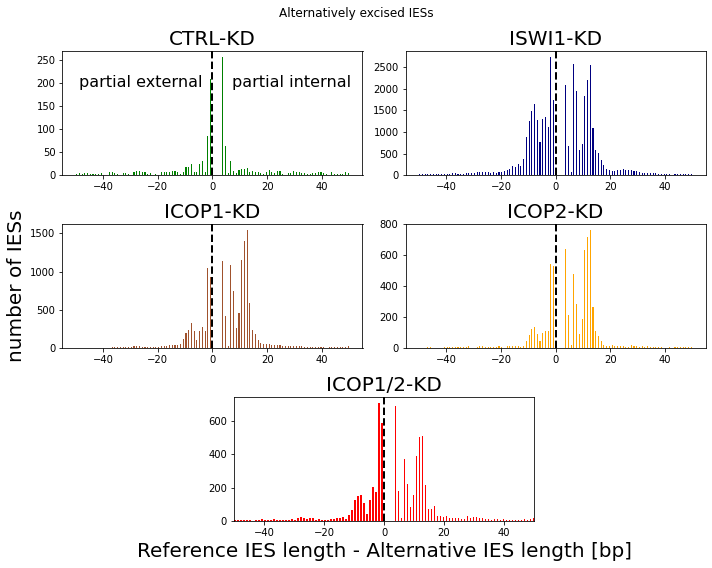

In [17]:
#set basic figure properties

fig, ax = plt.subplots(sharex=True, figsize = (10, 8));

ax0 = plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2)
ax1 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax2 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,2), colspan=2)
ax4 = plt.subplot2grid((3,4), (2,1), colspan=2)

ax0.hist((partial_storage[names[0]][0], partial_storage[names[0]][1]), bins=range(-50, 51), fc='green', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax1.hist((partial_storage[names[1]][0], partial_storage[names[1]][1]), bins=range(-50, 51), fc='navy', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax2.hist((partial_storage[names[2]][0], partial_storage[names[2]][1]), bins=range(-50, 51), fc='sienna', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax3.hist((partial_storage[names[3]][0], partial_storage[names[3]][1]), bins=range(-50, 51), fc='orange', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax4.hist((partial_storage[names[4]][0], partial_storage[names[4]][1]), bins=range(-50, 51), fc='red', 
         label = ['externally excised IESs', 'internally excised IESs']);


#add title to each subplot
ax0.set_title(names[0], fontsize = 20);
ax1.set_title(names[1], fontsize = 20);
ax2.set_title(names[2], fontsize = 20);
ax3.set_title(names[3], fontsize = 20);
ax4.set_title(names[4], fontsize = 20);

#add dashed vertical lines at x=0
ax0.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax1.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax2.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax3.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax4.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)


#set the min and max for the x-axis (shared by all)
#ax0.set_ylabel('number of IESs', fontsize=13);
ax2.set_ylabel('number of IESs', fontsize=20);
#ax4.set_ylabel('number of IESs', fontsize=13);

ax4.set_xlim([-50,50]);
ax4.set_xlabel('Reference IES length - Alternative IES length [bp]', fontsize=20);

#ax5.set_xticks(range(-50, 50, 10));

plt.suptitle("Alternatively excised IESs");
plt.tight_layout();
#fig.text(0.001, 0.5, 'number of IESs', ha='center', va='center', rotation='vertical');
#fig.text(0.5, 0.001, 'Reference IES length - Alternative IES length [bp]', 
#         ha='center', va='center', rotation='horizontal');
fig.text(0.20, 0.85, 'partial external', fontsize = 16, wrap=True,
         ha='center', va='center', rotation='horizontal');
fig.text(0.41, 0.85, 'partial internal', fontsize = 16,wrap=True,
         ha='center', va='center', rotation='horizontal');

fig.savefig("ICOPs_down_int_ext_large.pdf",bbox_inches='tight')

In [203]:
ref_ies_len_test = int(df_length.loc[df_length['IES_ID'] == 'IESPGM.PTET51.1.9.694727']["ref_length"])

In [205]:
ref_ies_len

108

In [199]:
len(sequence)

99

In [206]:
calc_len

98

In [201]:
ies_id

'IESPGM.PTET51.1.9.694727'

In [ ]:
df_length['IES_']

In [ ]:
#this script is to analyse parially internal and partially external excision

#specify the files you want to work on and the names you want to call them
unzip_gff = ["ND7_down_MILORD.gff3","ISWI1_down_MILORD.gff3", "ICOP1_down_MILORD.gff3", "ICOP2_down_MILORD.gff3",
       "ICOP1_2_MILORD.gff3"]
sam =["ND7","ISWI1","ICOP1","ICOP2","ICOP1_2"]

partial_storage = OrderedDict([(na, []) for na in sam])
zahl = int(-1)

#loop through KD data sets and read them into df
for fn in unzip_gff:
    zahl += 1
    alt = gffpd.read_gff3(fn)
    #create dfs with lines of the gff containing either internally or externally excised IESs
    df_alt_internal = alt.df[alt.df['attributes'].str.contains("PARTIAL_INTERNAL")]
    df_alt_external = alt.df[alt.df['attributes'].str.contains("PARTIAL_EXTERNAL")]
    #for santity checks
    #print(len(alt.df))
    #print(len(df_alt_internal))
    #print(len(df_alt_external))
    print(sam[zahl],'gff3 file has',len(alt.df),'lines.',len(df_alt_internal),
          'are entries with internal and',len(df_alt_external),'are entries with extranl excision.')
    
    #store all internally exicised IESs with their length difference in a dict
    len_d_int = {}

    for row in df_alt_internal.iterrows():
        #get the length of the alternative IES feature (end and start are column names in df)
        ies_len = row[1].end - row[1].start
        #get the name of the reference IES
        IES = [a for a in row[1]['attributes'].split(";") if "ies_id" in a][0].split("=")[1]
        #get the length of the reference IES using the name stored in "IES" variable
        ref_ies_len = int(df_lengths.loc[df_lengths['IES'] == IES]["IES_length"])
        #is this needed? also not completely correct: count = 'support_variant=2' ( .split("=")[1]) is missing)
        #count = [a for a in row[1]['attributes'].split(";") if "support_variant" in a][0]
        len_d_int.setdefault(IES, []).append(ref_ies_len - ies_len)
    
    #put the length differences (multiple for IESs possible) without IESs association in list
    all_lens_int = []
    for ies in len_d_int:
        for alen in len_d_int[ies]:
            all_lens_int.append(alen)
    
    #store all externally exicised IESs with their length difference in a dict
    len_d_ext = {}

    for row in df_alt_external.iterrows():
        ies_len = row[1].end - row[1].start
        IES = [a for a in row[1]['attributes'].split(";") if "ies_id" in a][0].split("=")[1]
        ref_ies_len = int(df_length.loc[df_length['IES_ID'] == IES]["ref_length"])
        #count = [a for a in row[1]['attributes'].split(";") if "support_variant" in a][0]
        len_d_ext.setdefault(IES, []).append(ref_ies_len - ies_len)
    
    #put the length differences (multiple for IESs possible) without IESs association in list
    all_ext_lens = []
    for ies in len_d_ext:
        for alen in len_d_ext[ies]:
            all_ext_lens.append(alen)
    
    #store both list in a list
    my_list = [all_ext_lens, all_lens_int]
    #store the name of the KD with both lists in the storage dict
    partial_storage[sam[zahl]].append(my_list)

In [182]:
len(forbidden_len['ND7-KD'])

101

In [181]:
len(forbidden_id['ND7-KD'])

101

In [196]:
df_length[:5]

,IES_ID,ref_length
0,IESPGM.PTET51.1.9.2325,495
1,IESPGM.PTET51.1.9.33017,65
2,IESPGM.PTET51.1.9.35389,133
3,IESPGM.PTET51.1.9.36829,73
4,IESPGM.PTET51.1.9.36845,106


In [155]:
len(extracted_values['ISWI1-KD'])

49834

In [129]:
type(dfs_len[names[count]])

pandas.core.frame.DataFrame

In [149]:
superhigh = dfs_len['ISWI1-KD'][(~np.isnan(dfs_len['ISWI1-KD'][19]))]

In [150]:
superhigh

,IES_ID,ref_length,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
15142,IESPGM.PTET51.1.164.188323,1860,9130,5031.0,4181.0,975.0,1934.0,1926.0,1924.0,1922.0,...,1878.0,1875.0,1865.0,1863.0,1849.0,1847.0,1759.0,59.0,56.0,942.0


In [145]:
dfs_len['ISWI1-KD'][:5]

,IES_ID,ref_length,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,IESPGM.PTET51.1.9.2325,495,485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IESPGM.PTET51.1.9.33017,65,63,57.0,73.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IESPGM.PTET51.1.9.36829,73,195,57.0,67.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IESPGM.PTET51.1.9.36845,106,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IESPGM.PTET51.1.9.37011,135,123,130.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
len(alt_len)

7897

In [118]:
len(df_altlen)

7897

In [119]:
df_altlen.shape

(7897, 9)

In [113]:
most = df_allen[(~np.isnan(df_allen[6]))]
most[:5]

,0,1,2,3,4,5,6
IESPGM.PTET51.1.61.426410,56,58.0,1246.0,1957.0,143.0,2002.0,26.0


In [111]:
len(df_allen[6])

7897

In [121]:
df_altlen[-5:]

,IES_ID,ref_length,0,1,2,3,4,5,6
7892,IESPGM.PTET51.1.556.143097,38,28,38.0,NaN,NaN,NaN,NaN,NaN
7893,IESPGM.PTET51.1.556.162596,29,31,NaN,NaN,NaN,NaN,NaN,NaN
7894,IESPGM.PTET51.1.556.205825,481,2346,620.0,84.0,NaN,NaN,NaN,NaN
7895,IESPGM.PTET51.1.556.211267,124,44,NaN,NaN,NaN,NaN,NaN,NaN
7896,IESPGM.PTET51.1.556.212459,55,58,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df_length[:5]

,IES_ID,ref_length
0,IESPGM.PTET51.1.9.2325,495
1,IESPGM.PTET51.1.9.33017,65
2,IESPGM.PTET51.1.9.35389,133
3,IESPGM.PTET51.1.9.36829,73
4,IESPGM.PTET51.1.9.36845,106


In [ ]:
#this script acquires the lengths of alternatively excised IESs

#fns = ["ND7_down_MILORD.gff3.gz","ISWI1_down_MILORD.gff3.gz","ICOP1_down_MILORD.gff3.gz",
#       "ICOP2_down_MILORD.gff3.gz", "ICOP1_2_MILORD.gff3.gz"]
#KDs=["ND7","ISWI1","ICOP1","ICOP2","ICOP1_2"]

len_storage = OrderedDict([(na, []) for na in KDs])
#zahl = int(-1)

# create data frame with reference IES lengths
df_length = pd.read_csv('IES_length.txt.gz',compression = 'gzip',sep=" ")

#loop through the samples
for fn in fns:
    ies_len = {}
    alt_len = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')
            subtype = atoms[-1].split(";")[-5].replace("subtype=", '')
            
            if kind == 'IES':
                sequence = atoms[-1].split(";")[11].replace("sequence=", '')
                ies_len[ies_id] = len(sequence)
            #for alternatively excised IES store the length of the alternative IES
            elif kind == 'ALTERNATIVE':
                sequence = atoms[-1].split(";")[11].replace("sequence=", '')
                alt_len.setdefault(ies_id, []).append(len(sequence))
                #Replace the above line with these two lines to count each read supporting alt excision
                #support_variant = int(atoms[-1].split(";")[-3].replace("support_variant=", ''))
                #for i in range(support_variant):
                    #alt_d.setdefault(ies_id, []).append(len(sequence))

    alt_lens = []
    for ies_id in alt_len:
        for l in alt_len[ies_id]:
            alt_lens.append(l)
    
    zahl += 1                
    len_storage[KDs[zahl]].append(alt_lens)

# if you want to plot "IES" and "ALTERNATIVE" for one KD
ies_lens = ies_len.values()

In [78]:
#check how many IES with alternative excision >= 50% are common among all samples (except ND7)
highs = []
frac_cols = []
for na in names:
    high_50 = df[df[f"{na}_frac"] >= 50]
    high_50 = high_50[['IES_ID', f"{na}_frac"]]
    highs.append(high_50)
    frac_cols.append(f"{na}_frac")

# combine to one df
df_high = reduce(lambda left,right: pd.merge(left,right,on=['IES_ID'], how='outer'), highs).fillna(np.nan)
# throw out rows where ND7-KD is higher 50
df_high_nN = df_high[~ (df_high['ND7-KD_frac'] >= 50)]

In [79]:
df_high.shape

(4973, 6)

In [80]:
df_high_nN.shape

(4029, 6)

In [70]:
for na in names:
    print(min(df_high[f"{na}_frac"]))

50.0
50.0
50.0
50.0
50.0


In [69]:
df_high[:5]

,IES_ID,ND7-KD_frac,ISWI1-KD_frac,ICOP1-KD_frac,ICOP2-KD_frac,ICOP1_2-KD_frac
0,IESPGM.PTET51.1.100.126280,100.0,100.0,100.0,100.0,100.0
1,IESPGM.PTET51.1.100.155500,100.0,100.0,100.0,100.0,100.0
2,IESPGM.PTET51.1.100.244570,100.0,100.0,100.0,100.0,100.0
3,IESPGM.PTET51.1.100.289356,100.0,100.0,100.0,100.0,100.0
4,IESPGM.PTET51.1.101.114019,100.0,100.0,100.0,100.0,100.0


In [56]:
len(df_data[df_data[f"{names[count]}_frac"]== 0])

33870

In [54]:
df.shape

(44226, 16)

In [55]:
df[:5]

,IES_ID,ND7-KD_std,ND7-KD_alt,ND7-KD_frac,ISWI1-KD_std,ISWI1-KD_alt,ISWI1-KD_frac,ICOP1-KD_std,ICOP1-KD_alt,ICOP1-KD_frac,ICOP2-KD_std,ICOP2-KD_alt,ICOP2-KD_frac,ICOP1_2-KD_std,ICOP1_2-KD_alt,ICOP1_2-KD_frac
0,IESPGM.PTET51.1.100.218,2.0,0.0,0.0,3.0,0.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN
1,IESPGM.PTET51.1.100.348,3.0,0.0,0.0,6.0,3.0,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
2,IESPGM.PTET51.1.100.478,5.0,0.0,0.0,4.0,1.0,0.200000,6.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0
3,IESPGM.PTET51.1.100.600,6.0,0.0,0.0,7.0,0.0,0.000000,7.0,0.0,0.0,1.0,0.0,0.0,9.0,0.0,0.0
4,IESPGM.PTET51.1.100.989,3.0,0.0,0.0,2.0,0.0,0.000000,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN


In [36]:
df_ies.shape

(41767, 2)

In [38]:
df_alt.shape

(41767, 2)

In [39]:
df_data.shape

(41767, 3)

In [44]:
df_show = df_data[df_data['ICOP1_2-KD_alt'] > 0]
df_show[:5]

,IES_ID,ICOP1_2-KD_std,ICOP1_2-KD_alt,ICOP1_2-KD_frac
23,IESPGM.PTET51.1.100.30724,5,2,0.285714
25,IESPGM.PTET51.1.100.40357,6,3,0.333333
27,IESPGM.PTET51.1.100.43950,3,1,0.250000
30,IESPGM.PTET51.1.100.48715,3,1,0.250000
32,IESPGM.PTET51.1.100.51654,4,1,0.200000


In [60]:
min(df_data['ICOP1_2-KD_frac'])

0.0

In [34]:
car = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}

x = car.setdefault("model", "Bronco")

print(x)

Mustang


In [ ]:
#this script analyses the percentage of alternative excision for each IES
# incoorperate storage of alternative excision in data frames

kd_alt_fracs = []
fns = ["ND7_down_MILORD.gff3.gz","ISWI1_down_MILORD.gff3.gz","ICOP1_down_MILORD.gff3.gz",
       "ICOP2_down_MILORD.gff3.gz", "ICOP1_2_MILORD.gff3.gz"]
names = ["ND7-KD","ISWI1-KD","ICOP1-KD", "ICOP2-KD", "ICOP1_2-KD"]

count = int(-1)
#storage = OrderedDict([(na, []) for na in names])
columns = []

#loop through samples
for fn in fns:
    count += 1
    ies_d = {}
    alt_d = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')

            #for each properly excised IES store the number of reads
            if kind == 'IES':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                ies_d.setdefault(ies_id, 0)
                ies_d[ies_id] += len(read_names)
                alt_d.setdefault(ies_id, 0)
            #for each alternatively excised IES store the number of reads (adds up for subtypes)
            elif kind == 'ALTERNATIVE':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                alt_d.setdefault(ies_id, 0)
                alt_d[ies_id] += len(read_names)
                
    df_ies = pd.DataFrame.from_dict(ies_d, )
               

    alt_fracs = []  
    
    for ies in ies_d:
        alt_count = alt_d[ies]
        ies_count = ies_d[ies]
        alt_frac = 100*float(alt_count)/(alt_count + ies_count) 
        alt_fracs.append(alt_frac)
        
    kd_alt_fracs.append(alt_fracs)
    
    colnames = ['sample','median', 'mean', 'all IES','IES==0', 'IES>0','IES>=50']
    columns.append([names[count], median(alt_fracs), mean(alt_fracs), len(ies_d), 
                    len([ies for ies in alt_d if alt_d[ies] == 0]),
                    len([ies for ies in alt_d if alt_d[ies] > 0]), 
                    len([1 for alt_frac in alt_fracs if alt_frac >= 50])])

table = pd.DataFrame(columns, columns = colnames).T
print(table.T)
#table.T.to_csv('ICOP-alex-medians.csv')

In [2]:
#this script analyses the percentage of alternative excision for each IES

kd_alt_fracs = []
fns = ["ND7_down_MILORD.gff3.gz","ISWI1_down_MILORD.gff3.gz","ICOP1_down_MILORD.gff3.gz",
       "ICOP2_down_MILORD.gff3.gz", "ICOP1_2_MILORD.gff3.gz"]
names = ["ND7-KD","ISWI1-KD","ICOP1-KD", "ICOP2-KD", "ICOP1_2-KD"]

count = int(-1)
storage = OrderedDict([(na, []) for na in names])
columns = []

#loop through samples
for fn in fns:
    count += 1
    ies_d = {}
    alt_d = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')

            #for each properly excised IES store the number of reads
            if kind == 'IES':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                ies_d.setdefault(ies_id, 0)
                ies_d[ies_id] += len(read_names)
                alt_d.setdefault(ies_id, 0)
            #for each alternatively excised IES store the number of reads (adds up for subtypes)
            elif kind == 'ALTERNATIVE':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                alt_d.setdefault(ies_id, 0)
                alt_d[ies_id] += len(read_names)
               

    alt_fracs = []  
    
    for ies in ies_d:
        alt_count = alt_d[ies]
        ies_count = ies_d[ies]
        alt_frac = 100*float(alt_count)/(alt_count + ies_count) 
        alt_fracs.append(alt_frac)
        
    kd_alt_fracs.append(alt_fracs)
    
    colnames = ['sample','median', 'mean', 'all IES','IES==0', 'IES>0','IES>=50']
    columns.append([names[count], median(alt_fracs), mean(alt_fracs), len(ies_d), 
                    len([ies for ies in alt_d if alt_d[ies] == 0]),
                    len([ies for ies in alt_d if alt_d[ies] > 0]), 
                    len([1 for alt_frac in alt_fracs if alt_frac >= 50])])

table = pd.DataFrame(columns, columns = colnames).T
print(table.T)
#table.T.to_csv('ICOP-alex-medians.csv')

       sample    median      mean all IES IES==0  IES>0 IES>=50
0      ND7-KD       0.0  1.077688   40680  39164   2147     313
1    ISWI1-KD  4.347826  9.180032   43171  18222  25761    1151
2    ICOP1-KD       0.0   7.01325   41349  28106  14131    1356
3    ICOP2-KD       0.0  4.181224   40785  34036   7537     906
4  ICOP1_2-KD       0.0  4.711392   40972  33870   7897    1196


In [165]:
#check how many IES with alternative excision >= 50% are common among all samples (except ND7)
in_common = []

for key in storage['ISWI1-KD'][0][0]:
    if key in storage['ICOP1-KD'][0][0]:
        if key in storage['ICOP2-KD'][0][0]:
            if key in storage['ICOP1_2-KD'][0][0]:
                in_common.append(key)
len(in_common)

38

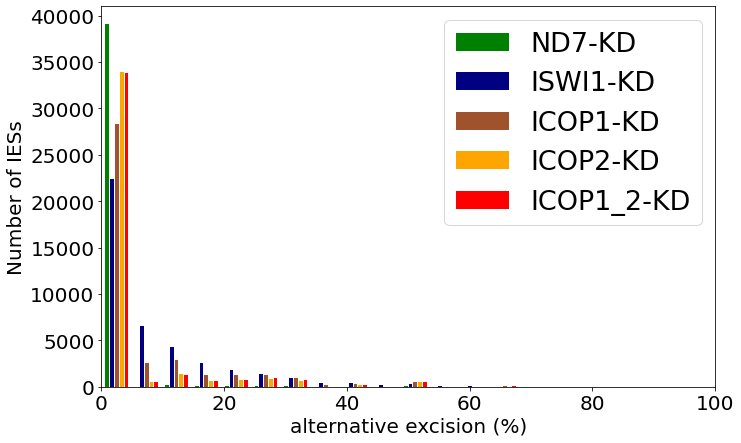

In [3]:
#plot the genome-wide alternative excision distribution (non-cropped)

plt.figure(figsize=(11,7))
hist(kd_alt_fracs, bins=20, ec='white', log=False, 
     color=['green', 'navy', 'sienna', 'orange', 'red'],
     label=names)
axis(ymax=41000, xmax=100, xmin=0)
plt.ylabel("Number of IESs", wrap = True, fontsize = 20)
plt.xlabel("alternative excision (%)", wrap = True, fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize = 27);


#plt.savefig("ICOPs_alt-ex_100_down.pdf", bbox_inches='tight')

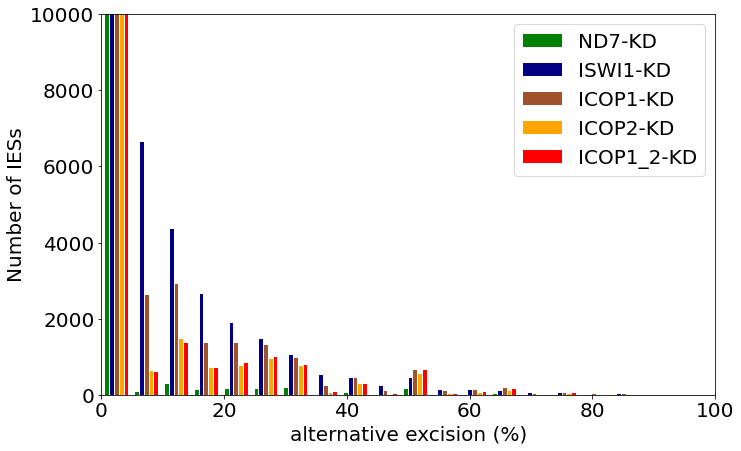

In [9]:
#plot the genome-wide alternative excision distribution (cropped)

plt.figure(figsize=(11,7))
hist(kd_alt_fracs, bins=20, ec='white', log=False, 
     color=['green', 'navy', 'sienna', 'orange', 'red'],
     label=names)
axis(ymax=10000, xmax=100, xmin=0)
plt.ylabel("Number of IESs", wrap = True, fontsize = 20)
plt.xlabel("alternative excision (%)", wrap = True, fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize = 20);


#plt.savefig("ICOPs_alt-ex_100_downS.pdf", bbox_inches='tight')

## Length distribution of alternatively excised IESs

In [14]:
#this script acquires the lengths of alternatively excised IESs

fns = ["ND7_down_MILORD.gff3.gz","ISWI1_down_MILORD.gff3.gz","ICOP1_down_MILORD.gff3.gz",
       "ICOP2_down_MILORD.gff3.gz", "ICOP1_2_MILORD.gff3.gz"]
KDs=["ND7","ISWI1","ICOP1","ICOP2","ICOP1_2"]

len_storage = OrderedDict([(na, []) for na in KDs])
zahl = int(-1)

#loop through the samples
for fn in fns:
    ies_len = {}
    alt_len = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')
            subtype = atoms[-1].split(";")[-5].replace("subtype=", '')
            
            if kind == 'IES':
                sequence = atoms[-1].split(";")[11].replace("sequence=", '')
                ies_len[ies_id] = len(sequence)
            #for alternatively excised IES store the length of the alternative IES
            elif kind == 'ALTERNATIVE':
                sequence = atoms[-1].split(";")[11].replace("sequence=", '')
                alt_len.setdefault(ies_id, []).append(len(sequence))
                #Replace the above line with these two lines to count each read supporting alt excision
                #support_variant = int(atoms[-1].split(";")[-3].replace("support_variant=", ''))
                #for i in range(support_variant):
                    #alt_d.setdefault(ies_id, []).append(len(sequence))

    alt_lens = []
    for ies_id in alt_len:
        for l in alt_len[ies_id]:
            alt_lens.append(l)
    
    zahl += 1                
    len_storage[KDs[zahl]].append(alt_lens)

# if you want to plot "IES" and "ALTERNATIVE" for one KD
ies_lens = ies_len.values()

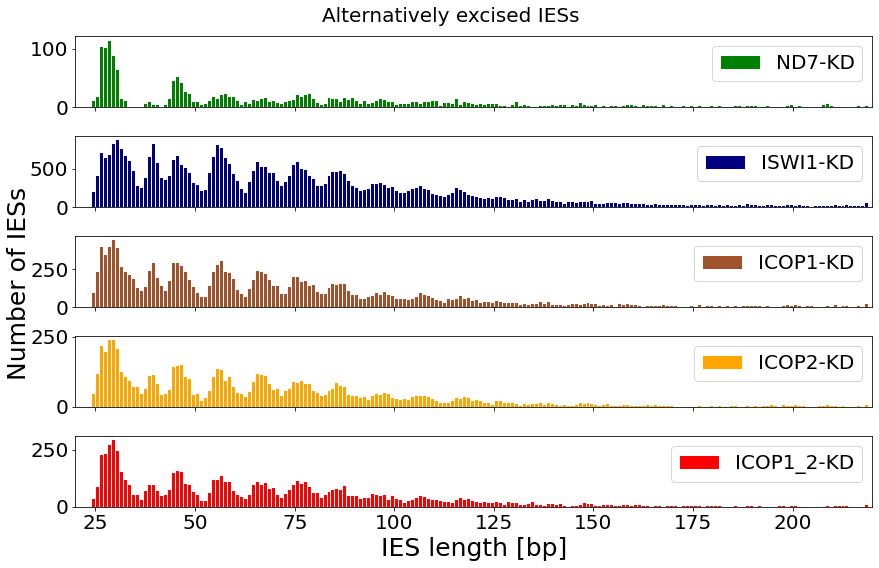

In [23]:
#set basic figure parameters

#plt.rcParams['figure.figsize'] = [12, 8]

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, ncols=1, sharex=True, figsize = (12,8));

ax0.hist(len_storage['ND7'], bins=range(20, 220, 1), ec='white', fc='green', 
         label = "ND7-KD");
ax1.hist(len_storage['ISWI1'], bins=range(20, 220, 1), ec='white', fc='navy', 
         label = "ISWI1-KD");
ax2.hist(len_storage['ICOP1'], bins=range(20, 220, 1), ec='white', fc='sienna', 
         label = "ICOP1-KD");
ax3.hist(len_storage['ICOP2'], bins=range(20, 220, 1), ec='white', fc='orange', 
         label = "ICOP2-KD");
ax4.hist(len_storage['ICOP1_2'], bins=range(20, 220, 1), ec='white', fc='red', 
         label = "ICOP1_2-KD");

ax0.legend(fontsize=20);
ax1.legend(fontsize=20);
ax2.legend(fontsize=20);
ax3.legend(fontsize=20);
ax4.legend(fontsize=20);

ax0.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)

ax4.set_xlabel('IES length [bp]', fontsize=25)
ax4.set_xlim([20,220]);

fig.suptitle("Alternatively excised IESs", fontsize=20);
fig.text(0.00001, 0.5, 'Number of IESs', ha='center', va='center', fontsize=25, rotation='vertical');
fig.tight_layout();

#fig.savefig("ICOPs_alt_length_down.pdf", bbox_inches='tight')

## Length differences partial internally and partial externally excised IESs

In [15]:
#this script is to analyse parially internal and partially external excision

#Read IES length data into dataframe
colnames=['IES', 'IES_length'] 
df_lengths = pd.read_csv("IES_lengths.txt", sep=" ", header = None, names=colnames)

#specify the files you want to work on and the names you want to call them
unzip_gff = ["ND7_down_MILORD.gff3","ISWI1_down_MILORD.gff3", "ICOP1_down_MILORD.gff3", "ICOP2_down_MILORD.gff3",
       "ICOP1_2_MILORD.gff3"]
sam =["ND7","ISWI1","ICOP1","ICOP2","ICOP1_2"]

partial_storage = OrderedDict([(na, []) for na in sam])
zahl = int(-1)

#loop through KD data sets and read them into df
for fn in unzip_gff:
    zahl += 1
    alt = gffpd.read_gff3(fn)
    #create dfs with lines of the gff containing either internally or externally excised IESs
    df_alt_internal = alt.df[alt.df['attributes'].str.contains("PARTIAL_INTERNAL")]
    df_alt_external = alt.df[alt.df['attributes'].str.contains("PARTIAL_EXTERNAL")]
    #for santity checks
    #print(len(alt.df))
    #print(len(df_alt_internal))
    #print(len(df_alt_external))
    print(sam[zahl],'gff3 file has',len(alt.df),'lines.',len(df_alt_internal),
          'are entries with internal and',len(df_alt_external),'are entries with extranl excision.')
    
    #store all internally exicised IESs with their length difference in a dict
    len_d_int = {}

    for row in df_alt_internal.iterrows():
        #get the length of the alternative IES feature (end and start are column names in df)
        ies_len = row[1].end - row[1].start
        #get the name of the reference IES
        IES = [a for a in row[1]['attributes'].split(";") if "ies_id" in a][0].split("=")[1]
        #get the length of the reference IES using the name stored in "IES" variable
        ref_ies_len = int(df_lengths.loc[df_lengths['IES'] == IES]["IES_length"])
        #is this needed? also not completely correct: count = 'support_variant=2' ( .split("=")[1]) is missing)
        #count = [a for a in row[1]['attributes'].split(";") if "support_variant" in a][0]
        len_d_int.setdefault(IES, []).append(ref_ies_len - ies_len)
    
    #put the length differences (multiple for IESs possible) without IESs association in list
    all_lens_int = []
    for ies in len_d_int:
        for alen in len_d_int[ies]:
            all_lens_int.append(alen)
    
    #store all externally exicised IESs with their length difference in a dict
    len_d_ext = {}

    for row in df_alt_external.iterrows():
        ies_len = row[1].end - row[1].start
        IES = [a for a in row[1]['attributes'].split(";") if "ies_id" in a][0].split("=")[1]
        ref_ies_len = int(df_lengths.loc[df_lengths['IES'] == IES]["IES_length"])
        #count = [a for a in row[1]['attributes'].split(";") if "support_variant" in a][0]
        len_d_ext.setdefault(IES, []).append(ref_ies_len - ies_len)
    
    #put the length differences (multiple for IESs possible) without IESs association in list
    all_ext_lens = []
    for ies in len_d_ext:
        for alen in len_d_ext[ies]:
            all_ext_lens.append(alen)
    
    #store both list in a list
    my_list = [all_ext_lens, all_lens_int]
    #store the name of the KD with both lists in the storage dict
    partial_storage[sam[zahl]].append(my_list)

ND7 gff3 file has 44623 lines. 720 are entries with internal and 771 are entries with extranl excision.
ISWI1 gff3 file has 100510 lines. 21264 are entries with internal and 20932 are entries with extranl excision.
ICOP1 gff3 file has 62404 lines. 10518 are entries with internal and 5152 are entries with extranl excision.
ICOP2 gff3 file has 50639 lines. 4962 are entries with internal and 2398 are entries with extranl excision.
ICOP1_2 gff3 file has 52686 lines. 4390 are entries with internal and 3162 are entries with extranl excision.


In [67]:
#this script is to analyse parially internal and partially external excision

from collections import defaultdict

#Read IES length data into dataframe
colnames=['IES', 'IES_length'] 
df_lengths = pd.read_csv("IES_lengths.txt", sep=" ", header = None, names=colnames)

#specify the files you want to work on and the names you want to call them
fns = ["ND7_down_MILORD.gff3.gz","ISWI1_down_MILORD.gff3.gz","ICOP1_down_MILORD.gff3.gz",
       "ICOP2_down_MILORD.gff3.gz", "ICOP1_2_MILORD.gff3.gz"]
sam = ["ND7-KD","ISWI1-KD","ICOP1-KD", "ICOP2-KD", "ICOP1_2-KD"]

partial_storage = OrderedDict([(na, []) for na in sam])
zahl = int(-1)

result = defaultdict(list)

for i, line in enumerate(lines(filename)):
    for key in line.keys():
        # This key has not been seen yet, so set it to None for all
        # previous lines.
        if key not in result:
            result[key] = [None] * i

        # Ensure this row has some value for each column.
        for key in result.keys():
            result[key].append(line.get(key, None))

alt_n = pd.DataFrame(result)

#loop through KD data sets and read them into df
for fn in fns:
    zahl += 1
    gff = gzip.open(fn, mode='rt')
    alt = gffpd.read_gff3(gff)
    #create dfs with lines of the gff containing either internally or externally excised IESs
    df_alt_internal = alt.df[alt.df['attributes'].str.contains("PARTIAL_INTERNAL")]
    df_alt_external = alt.df[alt.df['attributes'].str.contains("PARTIAL_EXTERNAL")]
    #for santity checks
    #print(len(alt.df))
    #print(len(df_alt_internal))
    #print(len(df_alt_external))
    print(sam[zahl],'gff3 file has',len(alt.df),'lines.',len(df_alt_internal),
          'are entries with internal and',len(df_alt_external),'are entries with extranl excision.')
    
    #store all internally exicised IESs with their length difference in a dict
    len_d_int = {}

    for row in df_alt_internal.iterrows():
        #get the length of the alternative IES feature (end and start are column names in df)
        ies_len = row[1].end - row[1].start
        #get the name of the reference IES
        IES = [a for a in row[1]['attributes'].split(";") if "ies_id" in a][0].split("=")[1]
        #get the length of the reference IES using the name stored in "IES" variable
        ref_ies_len = int(df_lengths.loc[df_lengths['IES'] == IES]["IES_length"])
        #is this needed? also not completely correct: count = 'support_variant=2' ( .split("=")[1]) is missing)
        #count = [a for a in row[1]['attributes'].split(";") if "support_variant" in a][0]
        len_d_int.setdefault(IES, []).append(ref_ies_len - ies_len)
    
    #put the length differences (multiple for IESs possible) without IESs association in list
    all_lens_int = []
    for ies in len_d_int:
        for alen in len_d_int[ies]:
            all_lens_int.append(alen)
    
    #store all externally exicised IESs with their length difference in a dict
    len_d_ext = {}

    for row in df_alt_external.iterrows():
        ies_len = row[1].end - row[1].start
        IES = [a for a in row[1]['attributes'].split(";") if "ies_id" in a][0].split("=")[1]
        ref_ies_len = int(df_lengths.loc[df_lengths['IES'] == IES]["IES_length"])
        #count = [a for a in row[1]['attributes'].split(";") if "support_variant" in a][0]
        len_d_ext.setdefault(IES, []).append(ref_ies_len - ies_len)
    
    #put the length differences (multiple for IESs possible) without IESs association in list
    all_ext_lens = []
    for ies in len_d_ext:
        for alen in len_d_ext[ies]:
            all_ext_lens.append(alen)
    
    #store both list in a list
    my_list = [all_ext_lens, all_lens_int]
    #store the name of the KD with both lists in the storage dict
    partial_storage[sam[zahl]].append(my_list)

NameError: name 'lines' is not defined

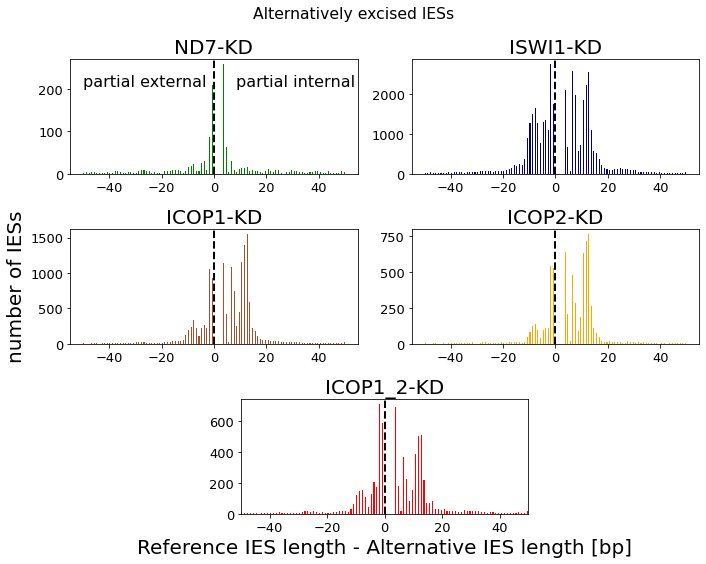

In [21]:
#set basic figure properties
rcParams.update({'figure.autolayout': True})
font = {'size' : 13}
matplotlib.rcParams['font.family'] = ['Arial', 'sans-serif']
matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = [10, 8]

fig, ax = plt.subplots(sharex=True);

ax0 = plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2)
ax1 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax2 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,2), colspan=2)
ax4 = plt.subplot2grid((3,4), (2,1), colspan=2)

ax0.hist((partial_storage['ND7'][0][0], partial_storage['ND7'][0][1]), bins=range(-50, 51), fc='green', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax1.hist((partial_storage['ISWI1'][0][0], partial_storage['ISWI1'][0][1]), bins=range(-50, 51), fc='navy', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax2.hist((partial_storage['ICOP1'][0][0], partial_storage['ICOP1'][0][1]), bins=range(-50, 51), fc='sienna', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax3.hist((partial_storage['ICOP2'][0][0], partial_storage['ICOP2'][0][1]), bins=range(-50, 51), fc='orange', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax4.hist((partial_storage['ICOP1_2'][0][0], partial_storage['ICOP1_2'][0][1]), bins=range(-50, 51), fc='red', 
         label = ['externally excised IESs', 'internally excised IESs']);


#add title to each subplot
ax0.set_title('ND7-KD', fontsize = 20);
ax1.set_title('ISWI1-KD', fontsize = 20);
ax2.set_title('ICOP1-KD', fontsize = 20);
ax3.set_title('ICOP2-KD', fontsize = 20);
ax4.set_title('ICOP1_2-KD', fontsize = 20);

#add dashed vertical lines at x=0
ax0.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax1.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax2.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax3.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax4.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)


#set the min and max for the x-axis (shared by all)
#ax0.set_ylabel('number of IESs', fontsize=13);
ax2.set_ylabel('number of IESs', fontsize=20);
#ax4.set_ylabel('number of IESs', fontsize=13);

ax4.set_xlim([-50,50]);
ax4.set_xlabel('Reference IES length - Alternative IES length [bp]', fontsize=20);

#ax5.set_xticks(range(-50, 50, 10));

plt.suptitle("Alternatively excised IESs");
plt.tight_layout();
#fig.text(0.001, 0.5, 'number of IESs', ha='center', va='center', rotation='vertical');
#fig.text(0.5, 0.001, 'Reference IES length - Alternative IES length [bp]', 
#         ha='center', va='center', rotation='horizontal');
fig.text(0.21, 0.85, 'partial external', fontsize = 16, wrap=True,
         ha='center', va='center', rotation='horizontal');
fig.text(0.42, 0.85, 'partial internal', fontsize = 16,wrap=True,
         ha='center', va='center', rotation='horizontal');

plt.savefig("ICOPs_down_int_ext_large.pdf",bbox_inches='tight')

In [257]:
#this script checks how many subtypes alternativly excsied IESs have

gffs = ["ND7_down_MILORD.gff3.gz","ISWI1_down_MILORD.gff3.gz","ICOP1_down_MILORD.gff3.gz",
       "ICOP2_down_MILORD.gff3.gz", "ICOP1_2_MILORD.gff3.gz"]
Kds=["ND7","ISWI1","ICOP1","ICOP2","ICOP1_2"]

subs_storage = OrderedDict([(na, []) for na in Kds])
multi_n_storage = OrderedDict([(na, []) for na in Kds])
zahl = int(-1)

for gz in gffs:
    zahl += 1
    alt_subs = {}
    
    for line in gzip.open(gz, mode='rt'):
        if line[0] != '#':
                atoms = line.split()  
                ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
                kind = atoms[-1].split(";")[-2].replace("type=", '')
                subtype = atoms[-1].split(";")[-5].replace("subtype=", '')
                
                if kind == 'ALTERNATIVE':
                    alt_subs.setdefault(ies_id, []).append(subtype)
                              
    subs_storage[Kds[zahl]].append(alt_subs)
    #get the alternative IES with mutliple subtypes
    a = [a for a in alt_subs if len(alt_subs[a]) > 1]
    b = [alt_subs[b] for b in alt_subs if len(alt_subs[b]) > 1]
    multi_types = dict(zip(a, b))
    #get number of subtypes for each IES
    c = [len(alt_subs[e]) for e in alt_subs if len(alt_subs[e]) > 1]
    multi_numbers = dict(zip(a, c))
    
    multi_n_storage[Kds[zahl]] = c
    
    
    #get the alternative IESs with multiple and different subtypes (assuming 2 subs per IES)
    #c = [c for c in multi if multi[c][0] != multi[c][1]]
    #d = [multi[d] for d in multi if multi[d][0] != multi[d][1]]
    #multi_diff = dict(zip(c, d))
    
    
    


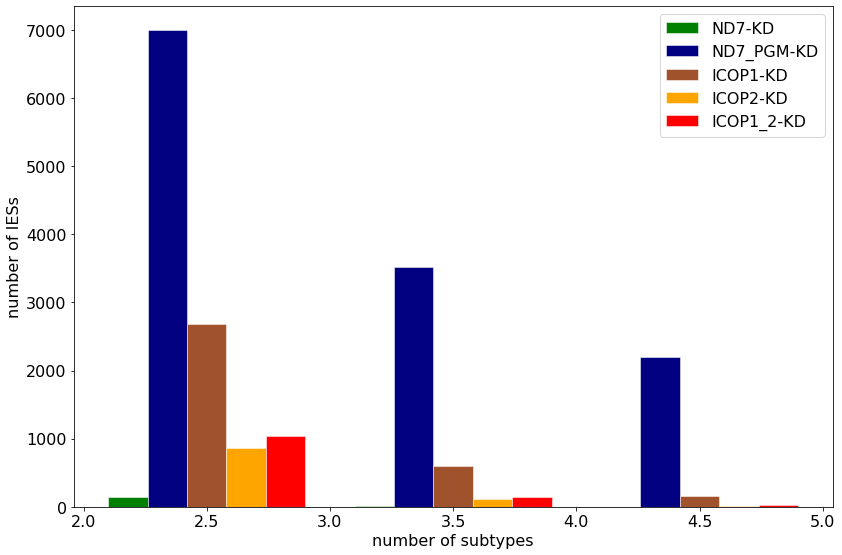

In [266]:
plt.hist(multi_n_storage.values(), color=['green','navy','sienna','orange','red'],
        bins=np.arange(2, 6, 1), ec='white', linewidth=0.5)

plt.xlabel('number of subtypes')
plt.ylabel('number of IESs')
plt.legend(['ND7-KD','ND7_PGM-KD','ICOP1-KD','ICOP2-KD','ICOP1_2-KD','ICOP1_2_PGM']);

In [298]:
min(partial_storage['ISWI1'][0][1])

3

In [ ]:
#!/usr/bin/env python
#Run after_ParTIES.py with the --help switch for usage information

from sys import argv
from matplotlib import *
from numpy import mean, std, array, arange, linspace
import matplotlib.cm as cm
import matplotlib.style as style
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.odr import ODR, Model, RealData
from statsmodels.nonparametric.smoothers_lowess import lowess
import argparse

def main(args, tick_font_size, label_font_size):
  lines = open(args.input_file).readlines()
  data_lines = lines[1:]
  experiment_names = lines[0].split()
  experiment_index = args.experiment_columns
  experiments = [experiment_names[ind] for ind in experiment_index]
  n_subfigs = len(experiments)

  corrected_p_threshold = args.alpha/sum(range(len(experiments))) 
  #Bonferroni correction

  def fit_func(B, x):
    """y = m*x + b"""
    return B[0]*x + B[1]

  linear = Model(fit_func)

  fig = plt.figure()
  color_generator = iter(cm.magma(arange(0, 1, 1.0/n_subfigs)))

  z = 0
  for i in range(n_subfigs):
    experiment1 = experiments[i]
    for j in range(n_subfigs):
      experiment2 = experiments[j]
      z += 1

      vals_1 = {}
      for line in data_lines:
        atoms = line.split()
        if atoms[experiment_index[i]] != 'NA':
          #exclude NA values generated by ParTIES
          score = float(atoms[experiment_index[i]])
          ctrl_mean = mean([float(atoms[n]) for n in range(len(atoms)) if n in args.control_columns])
          vals_1[atoms[0]] = max(score - ctrl_mean, 0)

      vals_2 = {}
      for line in data_lines:
        atoms = line.split()
        if atoms[experiment_index[j]] != 'NA':
          #exclude NA values generated by ParTIES
          score = float(atoms[experiment_index[j]])
          ctrl_mean = mean([float(atoms[n]) for n in range(len(atoms)) if n in args.control_columns])
          vals_2[atoms[0]] = max(score - ctrl_mean, 0)

      common_keys = set(vals_1.keys()) & set(vals_2.keys())

      x, y = [], []
      for akey in common_keys:
        x.append(vals_2[akey])
        y.append(vals_1[akey])

      slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
      rho, rho_p = stats.spearmanr(x, y)

      if i > j:
        if len(x) > 0 and len(y) > 0:
          plt.subplot(n_subfigs, n_subfigs, z)
          plt.hexbin(x, y, norm=LogNorm(vmin=args.hexbin_vmin, vmax=args.hexbin_vmax), mincnt=1, cmap=cm.viridis)

          max_max = max(max(x), max(y))
          xi = arange(0, max_max, 0.01)
          line = slope*xi+intercept

          mydata = RealData(array(x), array(y), sx=std(x), sy=std(y)) 

          if not args.deactivate_ODR:
            myodr = ODR(mydata, linear, beta0=[slope, intercept])
            ODR_out = myodr.run()
          
            if args.verbose:
              ODR_out.pprint()
            
            ODR_fitted_line = fit_func(ODR_out.beta, array(x))

          lowess_arr = lowess(y, x, delta=0.01, return_sorted=True)
          ys = lowess_arr[:,1]
          xs = lowess_arr[:,0]

          plt.plot(xs, ys,'orange',lw=args.regression_line_width)
          plt.plot(xi, line, ls='-', color='red', lw=args.regression_line_width)
          if not args.deactivate_ODR:
            plt.plot(x, ODR_fitted_line, "--", color='gray', lw=args.regression_line_width)

          plt.axis(xmax=1.01, ymax=1.01, ymin=-0.01, xmin=-0.01)

          ax = plt.gca()
          current_xticklabels = ax.get_xticks()
          fixed_xticklabels = ["%.1f" % (round(current_label, 1)) for current_label in current_xticklabels]
          current_yticklabels = ax.get_yticks()
          fixed_yticklabels = ["%.1f" % (round(current_label, 1)) for current_label in current_yticklabels]

          ax.yaxis.set_major_locator(mticker.FixedLocator(list(current_yticklabels)))
          ax.xaxis.set_major_locator(mticker.FixedLocator(list(current_xticklabels)))

          ax.set_xticklabels([])
          ax.set_yticklabels([])


          plt.tick_params(
          axis='both',
          which='both',
          top=False,
          right=False)

          if j == 0:
            #ax.set_xticklabels(fixed_xticklabels, fontsize=tick_font_size)
            ax.set_yticklabels(fixed_yticklabels, fontsize=tick_font_size)

            if args.show_axis_labels:
              ax.set_ylabel(experiment1, fontsize=label_font_size,
                rotation=90, style=args.font_style)
          if i == n_subfigs -1:
            ax.set_xticklabels(fixed_xticklabels, fontsize=tick_font_size, rotation=45)
            if args.show_axis_labels:
              ax.set_xlabel(experiment2, fontsize=label_font_size, style=args.font_style)


      elif i == j:
        plt.subplot(n_subfigs, n_subfigs, z)

        plt.tick_params(
        axis='both',
        which='both',
        top=False, 
        right=False)

        if len(x) > 0: 
          plt.hist(x, bins=arange(0, 1, 0.025), linewidth=0.3, ec="white",
            fc=next(color_generator))
          plt.axis(ymin=0, ymax=args.histogram_max)

          ax = plt.gca()
          ax.set_yticks(ax.get_yticks()[::2])

          ax.set_xticks(arange(0, 1.2, 0.2))
          current_xticklabels = ax.get_xticks()
          fixed_xticklabels = ["%.1f" % (round(current_label, 1)) for current_label in current_xticklabels]
          current_yticklabels = ax.get_yticks()
          fixed_yticklabels = ["%.1f" % (round(current_label, 1)) for current_label in current_yticklabels]

          ax.yaxis.set_major_locator(mticker.FixedLocator(list(current_yticklabels)))
          ax.xaxis.set_major_locator(mticker.FixedLocator(list(current_xticklabels)))

          ax.set_xticklabels([], fontsize=tick_font_size)
          ax.set_yticklabels(fixed_yticklabels, fontsize=tick_font_size)

          if i == n_subfigs -1:
            ax.set_xticklabels(fixed_xticklabels, fontsize=tick_font_size, rotation=45)

          if i > 0:
            plt.tick_params(
            axis='both',
            labelleft=False)
    
      else:
        plt.subplot(n_subfigs, n_subfigs, z)
        ax = plt.gca()
        current_xticklabels = ax.get_xticks()
        fixed_xticklabels = ["%.1f" % (round(current_label, 1)) for current_label in current_xticklabels]

        ax.yaxis.set_major_locator(mticker.FixedLocator(list(current_yticklabels)))
        ax.xaxis.set_major_locator(mticker.FixedLocator(list(current_xticklabels)))
        ax.set_xticklabels(fixed_xticklabels, fontsize=tick_font_size)
        

        if not args.use_pearson:
          ax.set_facecolor(cm.YlGnBu(rho))
          if rho > 0.5:
            if rho_p < corrected_p_threshold:
              plt.text(0.2, 0.4, "%.2f" % round(rho, 3), fontsize=1.5*label_font_size, color='white')
            else:
              plt.text(0.2, 0.4, "%.2f^" % round(rho, 3), fontsize=1.5*label_font_size, color='white')
          else:
            if rho_p < corrected_p_threshold:
              plt.text(0.2, 0.4, "%.2f" % round(rho, 3), fontsize=1.5*label_font_size, color='black')
            else:
              plt.text(0.2, 0.4, "%.2f^" % round(rho, 3), fontsize=1.5*label_font_size, color='black')
        else:
          ax.set_facecolor(cm.YlGnBu(r_value))
          if r_value > 0.5:
            plt.text(0.2, 0.4, "%.2f" % round(r_value, 3), fontsize=1.5*label_font_size, color='white')
          else:
            plt.text(0.2, 0.4, "%.2f" % round(r_value, 3), fontsize=1.5*label_font_size, color='black')

        plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False,
        labelright=False)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
  
  if args.show_colorbar:
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.4, 0.015, 0.4])

    cb_label = 'correlation plot hexbin scale (log10)'
    cb = plt.colorbar(cax=cbar_ax, drawedges=False,
      ticks=range(args.hexbin_vmin, args.hexbin_vmax+1), label=cb_label)
    #current_yticklabels = cbar_ax.get_yticks()
    #fixed_yticklabels = ["%.1f" % (round(current_label, 1)) for current_label in current_yticklabels]

    cbar_ax.set_yticklabels(range(args.hexbin_vmin, args.hexbin_vmax+1), fontsize=tick_font_size)
    cbar_ax.set_ylabel(cb_label, fontsize=label_font_size)
    cb.outline.set_linewidth(1)
    #cb.ax.get_children()[4].set_linewidths(1) 

  plt.savefig(args.output_matrix_image, dpi=((args.image_resolution)))

  
if __name__ == "__main__":
  parser = argparse.ArgumentParser(description=
"""Using the IES retention scores produced by ParTIES, generate a correlation matrix.
As an example, the following command should generate an image like the one in
Fig 3A of Swart et al. (all text between quotes type on a single line):
'python3.6 after_ParTIES.py --input_file ies_retention.tab 
--output_matrix_image ies_retention_knockdown_matrix.png 
--experiment_columns 1 2 3 10 6 5 7 4 9 12 --control_columns 11 12 13 14'
""")

  required_arg_group = parser.add_argument_group("required options")
  required_arg_group.add_argument("--input_file", required=True,
    help="Tab delimited file of IES retention scores from ParTIES.")
  required_arg_group.add_argument("--output_matrix_image", required=True,
    help="Output file for correlation matrix image. The suffix of the filename \
will determine the image type (e.g. .png = png file). For a few experiments pdf \
images can be generated, but for many onscreen rendering becomes too slow, \
and so either jpg or png files should be created.")
  required_arg_group.add_argument('--experiment_columns', metavar='E', type=int, nargs='+',
    required=True, help='One or more columns of IES retention scores from an \
experimental series of knockdowns.')
  required_arg_group.add_argument('--control_columns', metavar='N', type=int, nargs='+',
    required=True, help='One or more columns of IES retention scores from \
negative controls of experimental knockdowns.')

  optional_arg_group = parser.add_argument_group("Optional options")
  optional_arg_group.add_argument("--use_pearson", action="store_true",
    help="Add this option if Pearson's correlation is to be used instead of \
Spearman's correlation. In this case no p-value testing is performed.")
  optional_arg_group.add_argument("--alpha", default=0.01, type=float,
    help="Alpha used for p-value testing of Spearman's correlation coefficient \
(default: %(default)s); a Bonferroni correction is applied to this before \
testing, and when p > alpha/(number of hypotheses), a '^' character is shown \
next to the calculated correlation coefficient in the upper diagonal matrix. \
For example, for 10 experimental knockdowns the number of hypotheses is 45.")
  optional_arg_group.add_argument("--deactivate_ODR", action="store_true", default=False,
    help="Use this flag to turn of ODR for a speedup (default: %(default)s).")
  optional_arg_group.add_argument("--image_resolution", default=400, type=int,
    help="Change image resolution (default (in DPI): %(default)s).")
  optional_arg_group.add_argument("--base_font_size", default=14, type=int,
    help="Change font size (default: %(default)s).")
  optional_arg_group.add_argument("--font_style", default='italic',
    help="Change font style (default: %(default)s); options = normal, italic \
or oblique.")
  optional_arg_group.add_argument("--regression_line_width", default=1.2, type=int,
    help="Thickness of regression lines (default: %(default)s).")
  optional_arg_group.add_argument("--show_colorbar", 
    help="Show colorbar scale of hexagonal bins.", action="store_true")
  optional_arg_group.add_argument("--show_axis_labels", 
    help="Show labels on axes", default=True)
  optional_arg_group.add_argument("--histogram_max", default=9000, type=int,
    help="Maximum value of y-axis of the matrix diagonal's histograms (default: %(default)s).")
  optional_arg_group.add_argument("--hexbin_vmin", default=1, type=int,
    help="Minimum value of hexagonal bin counts (log10 scale) (default: %(default)s).")
  optional_arg_group.add_argument("--hexbin_vmax", default=1000, type=int,
    help="Maximum value of hexagonal bin counts (log10 scale) (default: %(default)s).")

  logging_arg_group = parser.add_argument_group("logging options")
  logging_arg_group.add_argument("--verbose", help="Display ODR output \
that may be useful for diagnostic purposes.", action="store_true")

  args = parser.parse_args()

  style.use('classic')
  #for the moment revert to classic style due to problems with axis
  #ticking in matplotlib 2.0.0
  rcParams['font.sans-serif'] = 'Arial'
  tick_font_size = args.base_font_size - len(args.experiment_columns)
  label_font_size = args.base_font_size - 0.75*len(args.experiment_columns)

  main(args, tick_font_size, label_font_size)


# vim: set sts=2 ts=2 sw=2: